In [1]:
from graph_tool.all import *
from collections import Counter,defaultdict
from tqdm import tqdm
import numpy as np

# Import necessary libraries
import pandas as pd
from scipy.sparse import csr_matrix, coo_matrix
from sklearn.preprocessing import LabelEncoder
import bz2
import pickle

# Ignore FutureWarning
import warnings
warnings.simplefilter('ignore')


# ADAPTATION FROM https://github.com/martingerlach/hSBM_Topicmodel

In [2]:
import seaborn as sns
import distinctipy
# change the default options of visualization
text_color = "#404040"

custom_params = {"axes.spines.right": False, "axes.spines.top": False, "axes.spines.left": True, "axes.spines.bottom": True,
                "lines.linewidth": 2, "grid.color": "lightgray", "legend.frameon": True,
                 "xtick.labelcolor": text_color, "ytick.labelcolor": text_color, "xtick.color": text_color, "ytick.color": text_color,"text.color": text_color,
                "axes.labelcolor": text_color, "axes.titlecolor":text_color,"figure.dpi": 200,
                "axes.titlelocation":"center","xaxis.labellocation":"center","yaxis.labellocation":"center"}


#palette = distinctipy.get_colors(21, pastel_factor=0.8)
wong = ['#332288', '#117733','#44AA99', '#88CCEE','#DDCC77', '#CC6677','#AA4499','#882255'  ]

palette = ['#264653', '#2a9d8f', '#f4a261','#e76f51']
sns.set_theme(context='paper', style='white', palette=palette, font_scale=1.1, color_codes=True,
rc=custom_params)
titles = ['U NP\nS NP',  'U NP\nS  P', 'U  P\nS NP','U  P\nS  P']

In [3]:
def edgelist(mat):

    # Assuming 'sparse_matrix' is your sparse matrix
    dense_matrix = mat.toarray()

    # Get the indices of the non-zero elements
    rows, cols = np.nonzero(dense_matrix)

    # Create a DataFrame from these indices
    df = pd.DataFrame({
        'user_id': [f'user_{row}' for row in rows], 
        'story_id': [f'story_{col}' for col in cols]
    })

    # If you want to include the weights (values of the non-zero elements)
    df['vote'] = dense_matrix[rows, cols]


    # Concatenate 'story_id' and 'username_vote' into a single series
    all_ids = pd.concat([df['story_id'], df['user_id']])
    # Apply LabelEncoder to the concatenated series
    encoder = LabelEncoder().fit(all_ids)

    # Transform 'story_id' and 'username_vote' using the fitted encoder
    df['story_index'] = encoder.transform(df['story_id'])
    df['user_index'] = encoder.transform(df['user_id'])


    edge_list = list(df[['story_index','user_index', 'vote']].itertuples(index=False, name=None))
    return edge_list

In [4]:
def graph(edge_list, n_users, labels):
    g = Graph(directed=False)
    g.add_edge_list(edge_list,  eprops=[('weight', 'int')])
    is_bip, part = is_bipartite(g, partition=True)
    if is_bip == False:
        print('Not bipartite!')
    signs = [0 if w <0 else 1 for w in g.ep.weight.a]
    size_a = len([v for v in g.vertices() if part[v] == 0])
    size_b = len([v for v in g.vertices() if part[v] == 1])
    users_real = min(range(len([size_a, size_b])), key=lambda index: abs([size_a, size_b][index] - n_users))
    if users_real == 0:
        kinds = [part[v] for v in g.vertices()]
        x = 0
        labels_ =[]
        for v in range(g.num_vertices()):
            if part[v] == 0:
                labels_.append(labels[x])
                x+=1
            else:
                labels_.append(999)
    else:    
        kinds = [part[v]+1  if part[v] == 0 else 0 for v in g.vertices()]
        x = 0
        labels_ =[]
        for v in range(g.num_vertices()):
            if part[v] == 1:
                labels_.append(labels[x])
                x+=1
            else:
                labels_.append(999)

 
    #docs - 0, words - 1
    #docs are users, words are stories
    

    color = ['red' if s == 0 else 'blue' for s in signs]
    g.vp['kind'] = g.new_vertex_property("int", vals=kinds)
    g.ep['sign'] = g.new_edge_property("int", vals=signs)
    g.ep['color'] = g.new_edge_property("string", vals=color)
    g.vp['label'] = g.new_vertex_property("int", vals=labels_)
    clabel = g.vp['kind']


    state_args_ = {'clabel': clabel, 'pclabel': clabel}

    return g, state_args_

In [5]:
def membership(g, state, bipartite=True):
    levels = state.get_levels()
    df_ = pd.DataFrame(columns=[f'level_{level}' for level in range(len(levels))])
    for i, level in enumerate(levels):
        for v in g.vertices():
            if bipartite ==True:
                #only look at the users
                if g.vp.kind[v] == 0:
                    membership = level.get_blocks()[v]
                    df_.loc[g.vertex_index[v], f'level_{i}'] = membership
            else:
                membership = level.get_blocks()[v]
                df_.loc[g.vertex_index[v], f'level_{i}'] = membership

    return df_

In [6]:
scenarios = ['u_np_s_np',  'u_np_s_p', 'u_p_s_np','u_p_s_p']

def load_matrices(path, scenarios=scenarios):
    return [pickle.load(open(f'{path}{scenario}.pkl', 'rb')) for scenario in scenarios]

def load_data(path, scenarios=scenarios):
    path_adj = path+'/adj/'
    path_labels = path+'/label/'
    file_names = [f'{scenario}.pkl' for scenario in scenarios]
    
    mats = [pickle.load(open(path_adj + f, 'rb')) for f in file_names]
    labels = [pickle.load(open(path_labels + f, 'rb')) for f in file_names]
    return mats, labels

In [7]:
from sklearn.metrics.cluster import rand_score

def rand_score_df(mats, labels, scenarios, membership_dict):
    # Create a dictionary to store the Rand scores
    rand_scores_dict = {}

    for i, mat in enumerate(mats):
        membership_df = membership_dict[scenarios[i]]

        # Compute Rand score with labels
        for level in range(len(state.levels)):
            RI = rand_score(labels[i], membership_df[f'level_{level}'])

            # Store the Rand score in the dictionary
            rand_scores_dict.setdefault(scenarios[i], {})[f'level_{level}'] = RI

    # Convert the dictionary to a DataFrame
    df = pd.DataFrame(rand_scores_dict).T

    return df

In [8]:
mats = load_matrices('./data/meneame/synth/uniform_new/bipartite/', scenarios=scenarios)
adj, labels = load_data('./data/meneame/synth/uniform_new/')
uniform_scenarios = [f'uniform/{scenario}' for scenario in scenarios]

# Bipartite network

In [9]:
states = {}
gs = {}
new_labels = []

for i, mat in enumerate(mats):
    edge_list = edgelist(mat)
    print(f'mat shape {mat.shape}')
    g, state_args = graph(edge_list, n_users=mat.shape[0], labels=labels[i])
    g, state_args = graph(edge_list, n_users=mat.shape[0], labels=labels[i])
    new_labels.append([x for x in list(g.vp.label) if x != 999])

    state = minimize_nested_blockmodel_dl(g, state_args=dict(recs=[g.ep.sign], rec_types=["discrete-binomial"],
                                                                deg_corr=True, **state_args), multilevel_mcmc_args=dict(verbose=False))
    states[scenarios[i]] = state
    gs[scenarios[i]] = g

mat shape (1000, 800)
mat shape (1000, 800)
mat shape (1000, 800)
mat shape (1000, 800)


In [10]:
membership_dict = {}
for i,mat in enumerate(mats):
    g = gs[scenarios[i]]
    state = states[scenarios[i]]
    
    membership_df = membership(g, state)
    membership_df.to_csv(f'./results/meneame/synth/uniform_new/bipartite/{scenarios[i]}_membership.csv', index=False)
    membership_dict[scenarios[i]] = membership_df

In [11]:
df_bip=rand_score_df(mats, new_labels, scenarios, membership_dict=membership_dict)
df_bip

,level_0,level_1,level_2,level_3,level_4,level_5,level_6,level_7,level_8,level_9,level_10,level_11
u_np_s_np,0.026176,0.044677,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
u_np_s_p,0.045776,0.070957,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
u_p_s_np,0.514256,0.500172,0.499518,0.499518,0.499518,0.499518,0.499518,0.499518,0.499518,0.499518,0.499518,0.499518
u_p_s_p,0.513088,0.499363,0.500582,0.500582,0.500582,0.500582,0.500582,0.500582,0.500582,0.500582,0.500582,0.500582


# Unipartite

In [12]:
from src.signet import *
import os
def sbm_uni(mat, degree_corrected=False):

    """Apply Stochastic Block Model community detection algorithm."""

    graph_build = SignedNetwork()
    g = graph_build.graph_construction(repre=mat, repre_type='adj', is_directed=check_if_directed(mat))
    state = minimize_nested_blockmodel_dl(g, state_args=dict(recs=[g.ep.sign],
                                                        rec_types=["discrete-binomial"],
                                                        deg_corr=degree_corrected))
    return g,state

In [17]:
membership_dict_uni = {}
for i, A in enumerate(adj):
    g,state = sbm_uni(A, degree_corrected=True)
    membership_df = membership(g, state, bipartite=False)
    membership_df.to_csv(f'./results/meneame/synth/uniform_new/unipartite/{scenarios[i]}_membership.csv', index=False)
    membership_dict_uni[scenarios[i]] = membership_df
    print(membership_df)

    level_0 level_1 level_2 level_3 level_4 level_5 level_6 level_7 level_8  \
0       989       0       1       0       0       0       0       0       0   
1       989       0       0       0       0       0       0       0       0   
2       989       0       0       0       0       0       0       0       0   
3       989       0       0       0       0       0       0       0       0   
4       989       0       0       0       0       0       0       0       0   
..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
995     989       0       0       0       0       0       0       0       0   
996     989       0       0       0       0       0       0       0       0   
997     989       8       0       0       0       0       0       0       0   
998     989       8       0       0       0       0       0       0       0   
999     654       0       0       0       0       0       0       0       0   

    level_9 level_10  
0         0        0  
1    

In [18]:
df_uni=rand_score_df(adj, labels, scenarios, membership_dict=membership_dict_uni)

,level_0,level_1,level_2,level_3,level_4,level_5,level_6,level_7,level_8,level_9,level_10
u_np_s_np,0.624757,0.644757,0.998000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
u_np_s_p,0.103035,0.184034,0.990040,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
u_p_s_np,0.552729,0.500895,0.500797,0.499868,0.499518,0.499518,0.499518,0.499518,0.499518,0.499518,0.499518
u_p_s_p,0.552126,0.499145,0.504859,0.501301,0.501301,0.501301,0.501301,0.501301,0.501301,0.501301,0.501301


In [53]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
dropbox_folder ='/Users/Cande007/Dropbox/Apps/Overleaf/2023_community_detection_on_signed_networks/'
text_size = 30

def plot_df(ax,df, titles=titles, text_size=text_size, leg=False):
    df.plot(kind='line',ax=ax,marker='s', markersize=3, linestyle='-', linewidth=10, alpha =0.7, legend=False)
    ax.set_xlabel('Levels', fontsize=text_size)
    ax.set_ylabel('Rand Index', fontsize=text_size)
    #plt.legend(loc='best')
    ax.tick_params(axis='both', labelsize=text_size)
    # set x-ticks text to only show the integer part
    ax.set_xticks(range(len(df.index)), range(len(df.index)))
    if leg:
        patchList = [mpatches.Patch(color=palette[key], label=title) for key, title in enumerate(titles)]
        plt.legend(handles=patchList, bbox_to_anchor=(1, 1), fontsize = text_size/1.5)

from src.commdet import create_directory  
def save_plot(path, filename, dropbox_folder=dropbox_folder):
    create_directory(path)
    create_directory(path.replace('./', f'{dropbox_folder}'))
    plt.savefig(path+filename)
    plt.savefig(path.replace('./', f'{dropbox_folder}')+filename)


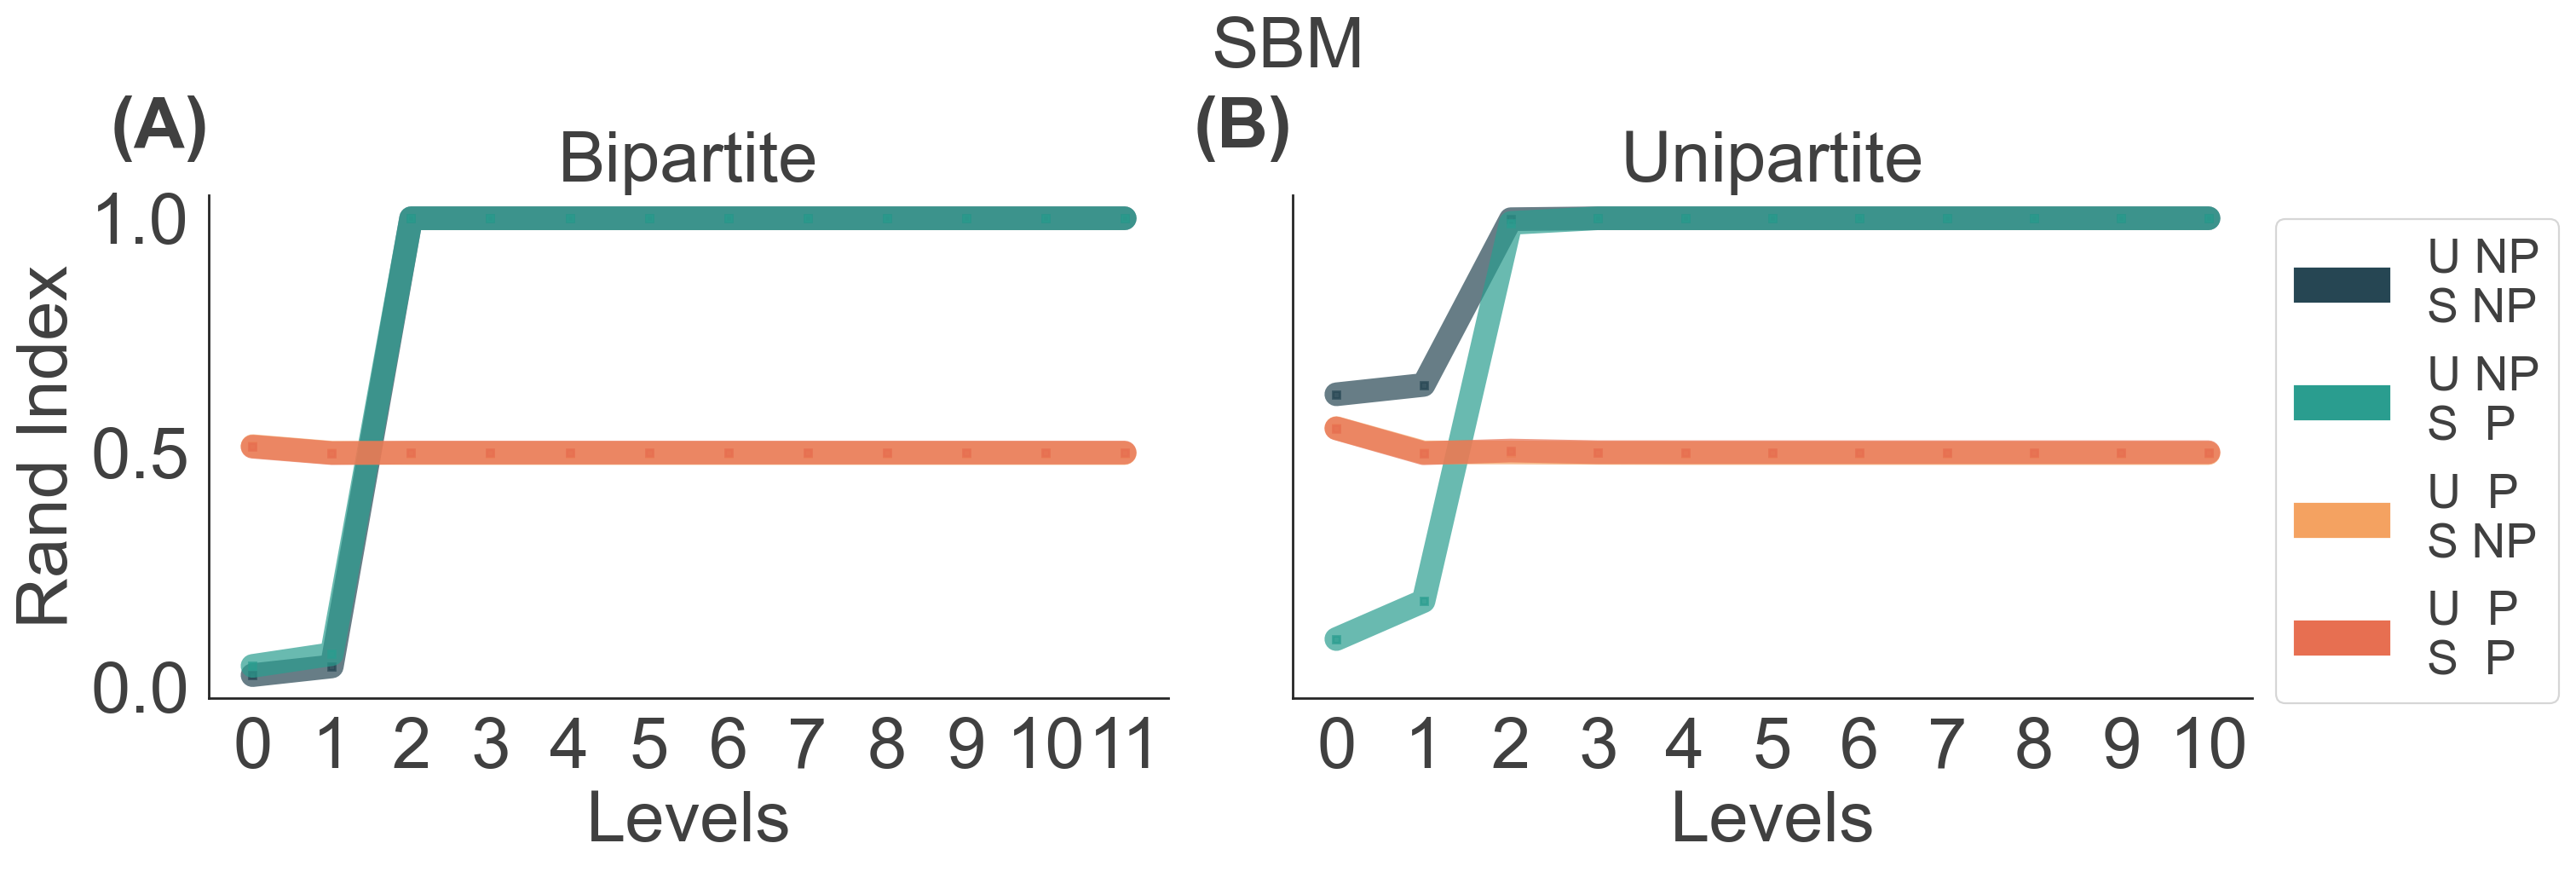

In [56]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize = (15,5),dpi =200, sharey=True, constrained_layout=True)

# Define panel letters
panel_labels = ['(A)', '(B)']

# Add panel letters to subplots
for i, ax in enumerate([ax1,ax2]):
    ax.text(0, 1.2, panel_labels[i], transform=ax.transAxes, fontsize=text_size, fontweight='bold', va='top', ha='right')

fig.suptitle('SBM', fontsize=text_size)

ax1.set_title('Bipartite', fontsize=text_size)
plot_df(ax1,df_bip.T)

ax2.set_title('Unipartite', fontsize=text_size)
plot_df(ax2,df_uni.T, leg = True)


save_plot(path = './plots/uniform/', filename = 'sbm.pdf')
plt.show()